# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The dataset consists of reviews of fine foods from Amazon products.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate way of determining the polarity (positivity/negativity) of a review.


In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/My Drive/AAIC/Food Reviews/'

/content/drive/My Drive/AAIC/Food Reviews


filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

filtered_data = pd.read_sql_query(""" 
                                    SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000
                                  """, con)

In [5]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# Give reviews with Score>3 a positive rating (1), and reviews with a score<3 a negative rating (0).
def partition(x):
    if x < 3:
        return 0
    return 1
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Lets find some data anamolies like:
* Check if there are any duplicate reviews given by a user

In [7]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
WHERE Score != 3
GROUP BY UserId, ProductId, ProfileName, Time, Score, Text
HAVING COUNT(*)>1
""", con)

print(display.shape)
display.head()

(734, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,A10GBEDF4RCOVI,B0037272UY,Superchiller,1310774400,1,"My girlfriend and I have been rescuing, foster...",2
1,A10NJPL8SA82WC,B0026RQTGE,STANIMAL,1343779200,5,These things are awesome. These Greenies real...,2
2,A10NJPL8SA82WC,B002QWHJOU,STANIMAL,1343779200,5,These things are awesome. These Greenies real...,2
3,A10NJPL8SA82WC,B002QWP89S,STANIMAL,1343779200,5,These things are awesome. These Greenies real...,2
4,A10NJPL8SA82WC,B002QWP8H0,STANIMAL,1343779200,5,These things are awesome. These Greenies real...,2


In [8]:
display.head(100)

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,A10GBEDF4RCOVI,B0037272UY,Superchiller,1310774400,1,"My girlfriend and I have been rescuing, foster...",2
1,A10NJPL8SA82WC,B0026RQTGE,STANIMAL,1343779200,5,These things are awesome. These Greenies real...,2
2,A10NJPL8SA82WC,B002QWHJOU,STANIMAL,1343779200,5,These things are awesome. These Greenies real...,2
3,A10NJPL8SA82WC,B002QWP89S,STANIMAL,1343779200,5,These things are awesome. These Greenies real...,2
4,A10NJPL8SA82WC,B002QWP8H0,STANIMAL,1343779200,5,These things are awesome. These Greenies real...,2
...,...,...,...,...,...,...,...
95,A1TMAVN4CEM8U8,B0034KN29O,Gunner,1332115200,5,Diamond Almonds<br />Almonds are a good source...,2
96,A1TMAVN4CEM8U8,B0034KP00S,Gunner,1332115200,5,Diamond Almonds<br />Almonds are a good source...,2
97,A1TMAVN4CEM8U8,B0049Z5OSK,Gunner,1332115200,5,Diamond Almonds<br />Almonds are a good source...,2
98,A1TMAVN4CEM8U8,B0049Z9ANU,Gunner,1332115200,5,Diamond Almonds<br />Almonds are a good source...,2


In [9]:
sample1 = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
and UserId = "A10NJPL8SA82WC"
""", con)
print(sample1.shape)

(8, 10)


In [10]:
sample1.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,21114,B002QWP89S,A10NJPL8SA82WC,STANIMAL,0,0,5,1343779200,Awesome Product,These things are awesome. These Greenies real...
1,21115,B002QWP89S,A10NJPL8SA82WC,STANIMAL,0,0,5,1343779200,Awesome Product,These things are awesome. These Greenies real...
2,74763,B0026RQTGE,A10NJPL8SA82WC,STANIMAL,0,0,5,1343779200,Awesome Product,These things are awesome. These Greenies real...
3,74764,B0026RQTGE,A10NJPL8SA82WC,STANIMAL,0,0,5,1343779200,Awesome Product,These things are awesome. These Greenies real...
4,329544,B002QWHJOU,A10NJPL8SA82WC,STANIMAL,0,0,5,1343779200,Awesome Product,These things are awesome. These Greenies real...
5,329545,B002QWHJOU,A10NJPL8SA82WC,STANIMAL,0,0,5,1343779200,Awesome Product,These things are awesome. These Greenies real...
6,355635,B002QWP8H0,A10NJPL8SA82WC,STANIMAL,0,0,5,1343779200,Awesome Product,These things are awesome. These Greenies real...
7,355636,B002QWP8H0,A10NJPL8SA82WC,STANIMAL,0,0,5,1343779200,Awesome Product,These things are awesome. These Greenies real...


In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

### Drop duplicates

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

Found rows where HelpfulnessNumerator is greater than HelpfulnessDenominator. These records are not valid, hence dropping them

In [14]:
final[final.HelpfulnessNumerator>final.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

# Text Preprocessing.

In the Preprocessing phase we do the following in the order below:-

* Begin by removing the html tags
* Remove any punctuations or limited set of special characters like , or . or # etc.
* Check if the word is made up of english letters and is not alpha-numeric
* Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
* Convert the word to lowercase
* Remove Stopwords
* Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
* After which we collect the words used to describe positive and negative reviews

In [17]:
final['Text'].values[100]

"Just an FYI to other customers: This item is for the Beef and Ocean Fish formula which is in a RED bag. In my haste, I purchased this thinking it was a the 15lb version of the Chicken and Rice formula. Woops! So I went and bought the 15lb bag of Chicken and Rice and mix the Beef and Fish in so it didn't wreak havoc on my pup's digestive system.<br /><br />I can say that after we started feeding this to my pup, she starting having stinky farts and had never had them before. Also, Roshan's right about the fish breath! Ick.<br /><br />Overall, my dog has no issues with this formula, it's just stinky so I'll stick to Chicken and Rice after this bag is done."

In [18]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    # remove urls
    sentance = re.sub(r"http\S+", "", sentance)
    # remove-all-tags-from-an-element
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    
    sentance = decontracted(sentance)
    #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:15<00:00, 2987.22it/s]


In [21]:
preprocessed_reviews[100]

'fyi customers item beef ocean fish formula red bag haste purchased thinking version chicken rice formula woops went bought bag chicken rice mix beef fish not wreak havoc pup digestive system say started feeding pup starting stinky farts never also roshan right fish breath ick overall dog no issues formula stinky stick chicken rice bag done'

## BAG OF WORDS

In [22]:
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## TF-IDF

In [23]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[50:100])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['abundant', 'abundant mineral', 'acacia', 'academy', 'academy sciences', 'acai', 'accent', 'accept', 'accept returns', 'acceptable', 'accepted', 'accepted throughout', 'access', 'accident', 'accidentally', 'accidently', 'accidents', 'accompanied', 'accompaniment', 'accompany', 'accompanying', 'accomplish', 'according', 'according directions', 'according instructions', 'according label', 'according package', 'accordingly', 'account', 'accounts', 'accurate', 'accurately', 'accustomed', 'acerola', 'acerola juice', 'acesulfame', 'ache', 'aches', 'achieve', 'achieved', 'acid', 'acid coffee', 'acid french', 'acid natural', 'acid not', 'acid reflux', 'acid vitamin', 'acidic', 'acidic taste', 'acidity']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## Word2Vec

In [24]:
# Train Word2Vec model using document text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [25]:
len(list_of_sentance)

46071

In [26]:
# Using Google News Word2Vectors
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('awesome', 0.8514646291732788), ('fantastic', 0.8422157764434814), ('good', 0.8096615672111511), ('amazing', 0.7984889149665833), ('terrific', 0.7942896485328674), ('excellent', 0.7924020886421204), ('perfect', 0.7825000882148743), ('wonderful', 0.7529447674751282), ('decent', 0.6875823140144348), ('nice', 0.6694883704185486)]
[('nastiest', 0.7206695079803467), ('best', 0.7141876220703125), ('greatest', 0.7067942023277283), ('experienced', 0.6309835910797119), ('awful', 0.6307783722877502), ('disgusting', 0.6250405311584473), ('eaten', 0.6230708956718445), ('hottest', 0.6210761070251465), ('tastiest', 0.6173089742660522), ('ive', 0.61635822057724)]


In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


In [28]:
w2v_model.wv.most_similar('tasty')

[('satisfying', 0.8261624574661255),
 ('delicious', 0.7745772004127502),
 ('yummy', 0.7710222601890564),
 ('filling', 0.7449297308921814),
 ('surprisingly', 0.7163609266281128),
 ('flavorful', 0.6984941363334656),
 ('crisp', 0.698255717754364),
 ('hearty', 0.6867802143096924),
 ('terrific', 0.655419111251831),
 ('crunchy', 0.654199481010437)]

## Avg W2v

In [29]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46071/46071 [01:29<00:00, 515.59it/s]

46071
50


In [30]:
sent_vectors[0]

array([-0.33843901,  0.7862743 , -0.12754929, -0.23941336, -0.33635877,
        0.0920174 ,  0.01691901, -0.27680094,  0.45638093,  0.04653111,
        0.22348061, -0.51381091, -0.29945465, -0.88611384,  0.52910374,
       -0.18935876, -0.13672871, -0.9356862 , -0.61737091,  0.2880545 ,
        0.03189598, -0.28176454, -0.27735644, -1.2153586 , -0.36975916,
       -0.19672124,  0.14850117, -0.14080425, -0.9157783 ,  0.37383581,
        0.24104813, -0.66889502,  0.69854136,  0.13184505, -0.00552285,
        0.55387089, -0.33270886,  0.38414767,  0.30252611, -0.10839285,
        0.59290399, -0.27710167,  0.36995518, -0.2744194 , -0.22872246,
        0.54899015,  0.5574846 , -0.02677658,  0.15055953, -0.22563725])

## Logistic Regression on these feature sets
* Review text, preprocessed one converted into vectors using (BOW)
* Review text, preprocessed one converted into vectors using (TFIDF)
* Review text, preprocessed one converted into vectors using (AVG W2v)

### Logistic Regression on BOW

In [31]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
X=preprocessed_reviews

In [42]:
y=np.array(final['Score'])
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

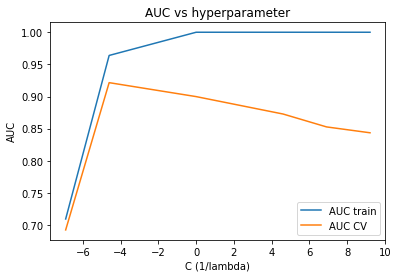

optimal lambda for which auc is maximum :  99.0


In [43]:
count_vect = CountVectorizer()
X_train=count_vect.fit_transform(X_train)
X_cv=count_vect.transform(X_cv)
X_test=count_vect.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train = scalar.fit_transform(X_train)
X_test= scalar.transform(X_test)
X_cv=scalar.transform(X_cv)

C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for c in C:
    lr=LogisticRegression(penalty='l1',C=c, solver='liblinear',verbose=True)
    lr.fit(X_train,y_train)
    probcv=lr.predict_proba(X_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(X_train)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


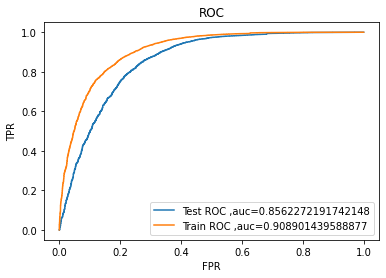

In [44]:
#ROC for lambda=99
lr=LogisticRegression(penalty='l1',C=optimal_c, solver='saga')
lr.fit(X_train,y_train)
predi=lr.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


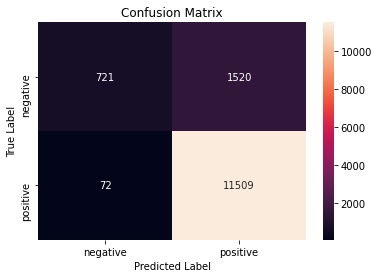

In [36]:
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
lr=LogisticRegression(penalty='l1',C=optimal_c, solver='saga')
lr.fit(X_train,y_train)
predic=lr.predict(X_test)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Calculating sparsity on weight vector obtained using L1 regularization on BOW

In [37]:
# Please write all the code with proper documentation
#lr=LogisticRegression(penalty='l1',C=optimal_c,  solver='saga')
#lr.fit(X_train,y_train)
weight=lr.coef_
#Sparsity of vector weight=no of zero in weight vector
print('No of non zero element in weight vector ',np.count_nonzero(weight))

No of non zero element in weight vector  3745


### Feature Importance on BOW,

In [46]:
all_features = count_vect.get_feature_names()

In [47]:
weight=lr.coef_
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])

Top 10 positive features :
great
love
good
best
delicious
loves
favorite
perfect
excellent
wonderful


In [48]:
print('Top 10 negative features :')
for i in list(neg_indx[0][:10]):
    print(all_features[i])

Top 10 negative features :
worst
awful
disappointed
horrible
disappointing
return
bad
refund
disgusting
threw


## Logistic Regression on TFIDF

### Logistic Regression with L1 regularization on TFIDF

In [50]:
y=np.array(final['Score'])
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

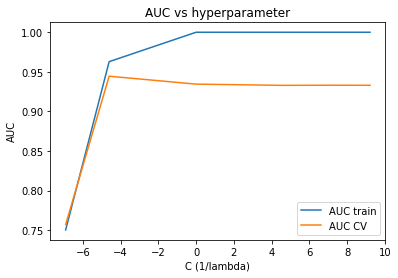

optimal lambda for which auc is maximum :  99.0


In [52]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train_tf=tf_idf_vect.fit_transform(X_train)
X_cv_tf=tf_idf_vect.transform(X_cv)
X_test_tf=tf_idf_vect.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train_tf = scalar.fit_transform(X_train_tf)
X_test_tf= scalar.transform(X_test_tf)
X_cv_tf=scalar.transform(X_cv_tf)

C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for c in C:
    lr=LogisticRegression(penalty='l1',C=c, solver='saga')
    lr.fit(X_train_tf,y_train)
    probcv=lr.predict_proba(X_cv_tf)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(X_train_tf)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


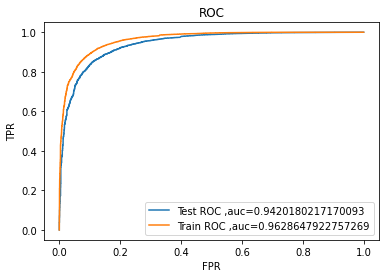

In [53]:
lr=LogisticRegression(penalty='l1',C=optimal_c, solver='saga')
lr.fit(X_train_tf,y_train)
predi=lr.predict_proba(X_test_tf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(X_train_tf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


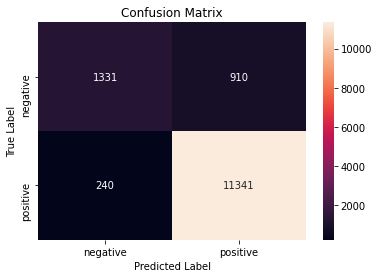

In [54]:
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
lr=LogisticRegression(penalty='l1',C=optimal_c, solver='saga')
lr.fit(X_train_tf,y_train)
predic=lr.predict(X_test_tf)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Logistic Regression on AVG W2V

In [55]:
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

#for cross validation we can use same w2v models and w2v words
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))   

#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

  1%|          | 59/9675 [00:00<00:16, 589.88it/s]

22574
50


100%|██████████| 9675/9675 [00:14<00:00, 667.23it/s]


9675
50


100%|██████████| 13822/13822 [00:21<00:00, 638.15it/s]

13822
50


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


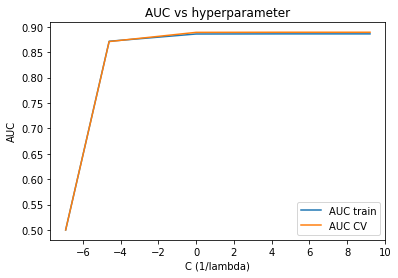

optimal lambda for which auc is maximum :  0


In [57]:
X_train_w2v=sent_vectors_train
X_cv_w2v=sent_vectors_cv
X_test_w2v=sent_vectors_test

C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for c in C:
    lr=LogisticRegression(penalty='l1',C=c, solver='saga')
    lr.fit(X_train_w2v,y_train)
    probcv=lr.predict_proba(X_cv_w2v)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(X_train_w2v)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


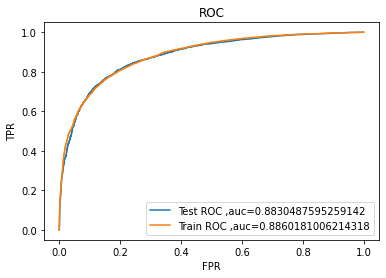

In [59]:
lr=LogisticRegression(penalty='l1',C=optimal_c, solver='saga')
lr.fit(X_train_w2v,y_train)
predi=lr.predict_proba(X_test_w2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(X_train_w2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


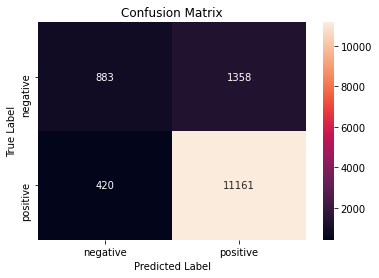

In [60]:
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
lr=LogisticRegression(penalty='l1',C=optimal_c, solver='saga')
lr.fit(X_train_w2v,y_train)
predic=lr.predict(X_test_w2v)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()